### Hackathon XPE

<p>Projeto Time 20 - Aplicando Machine learning para prever valores de venda de imóveis</p>
<p>Origem dos dados para treino: <a>https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf</a></p>

In [1]:
import pickle
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder 
import seaborn as sb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import is_object_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pickle

## Carregando e Compreendendo os Dados

In [2]:
df = pd.read_csv('./dados/train.csv')

In [3]:
# Escolhido campos que são mais compatíveis com as características dos imoveis brasileiros

lista_campos = [
    'LotArea', # Tamanho do lote em pés quadrados
    'Condition1', # proximidade a estação
    'Condition2', # Proximidade da estrada principal ou ferrovia (se houver uma segunda)
    'Street', # Tipo de estrada de acesso à propriedade
    'LotShape', # Forma geral da propriedade
    'Utilities', #  Tipo de utilitários disponíveis
    'GrLivArea', # Área de estar acima do nível do solo (pés quadrados)
    'BldgType', # Tipo de habitação
    'OverallQual', # Avalia o material geral e o acabamento da casa
    'OverallCond', # Avalia o estado geral da casa
    'YearBuilt', # Data original de construção
    'YearRemodAdd', #  Data da remodelação (igual à data de construção, se não houver reformas)
    'RoofMatl', # Material de telhado
    'Exterior1st', # Cobertura externa da casa
    'ExterCond', # Condição atual do material no exterior
    'Foundation', # Tipo de fundação
    'Electrical', # Sistema elétrico
    '1stFlrSF', # Primeiro andar pés quadrados
    '2ndFlrSF', # Segundo andar pés quadrados
    'FullBath', # Banheiros completos acima do nível do solo
    'BedroomAbvGr', # Número de quartos acima do nível do subsolo
    'KitchenQual', # Qualidade da cozinha
    'TotRmsAbvGrd', # Total de cômodos acima do nível do solo (não inclui banheiros)
    'GarageCars', # Tamanho da garagem em capacidade de carros
    'GarageArea', # Tamanho da garagem em pés quadrados
    'OpenPorchSF', # Área de varanda aberta em pés quadrados
    'PoolArea', # Área da piscina em pés quadrados
    'MoSold', # Mes de Venda
    'YrSold', # Ano de Venda
    'SaleCondition', # Condição da venda
    'SalePrice', # Preço de Venda

]

In [4]:
# Cria dataframe separado para verificar a correlação
# e transformar as variaveis categoricas em variaveis numéricas
# usando a função de LabelEncoder
df_corr = df[lista_campos]

label_encoder = LabelEncoder()

for column in lista_campos:

    if is_object_dtype(df[column]):
        # print("colunas é string:", column)
        df_corr[column] = label_encoder.fit_transform(df_corr[column])

C:\Users\lele_\AppData\Local\Temp\ipykernel_25048\2043082482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[column] = label_encoder.fit_transform(df_corr[column])
C:\Users\lele_\AppData\Local\Temp\ipykernel_25048\2043082482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[column] = label_encoder.fit_transform(df_corr[column])
C:\Users\lele_\AppData\Local\Temp\ipykernel_25048\2043082482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

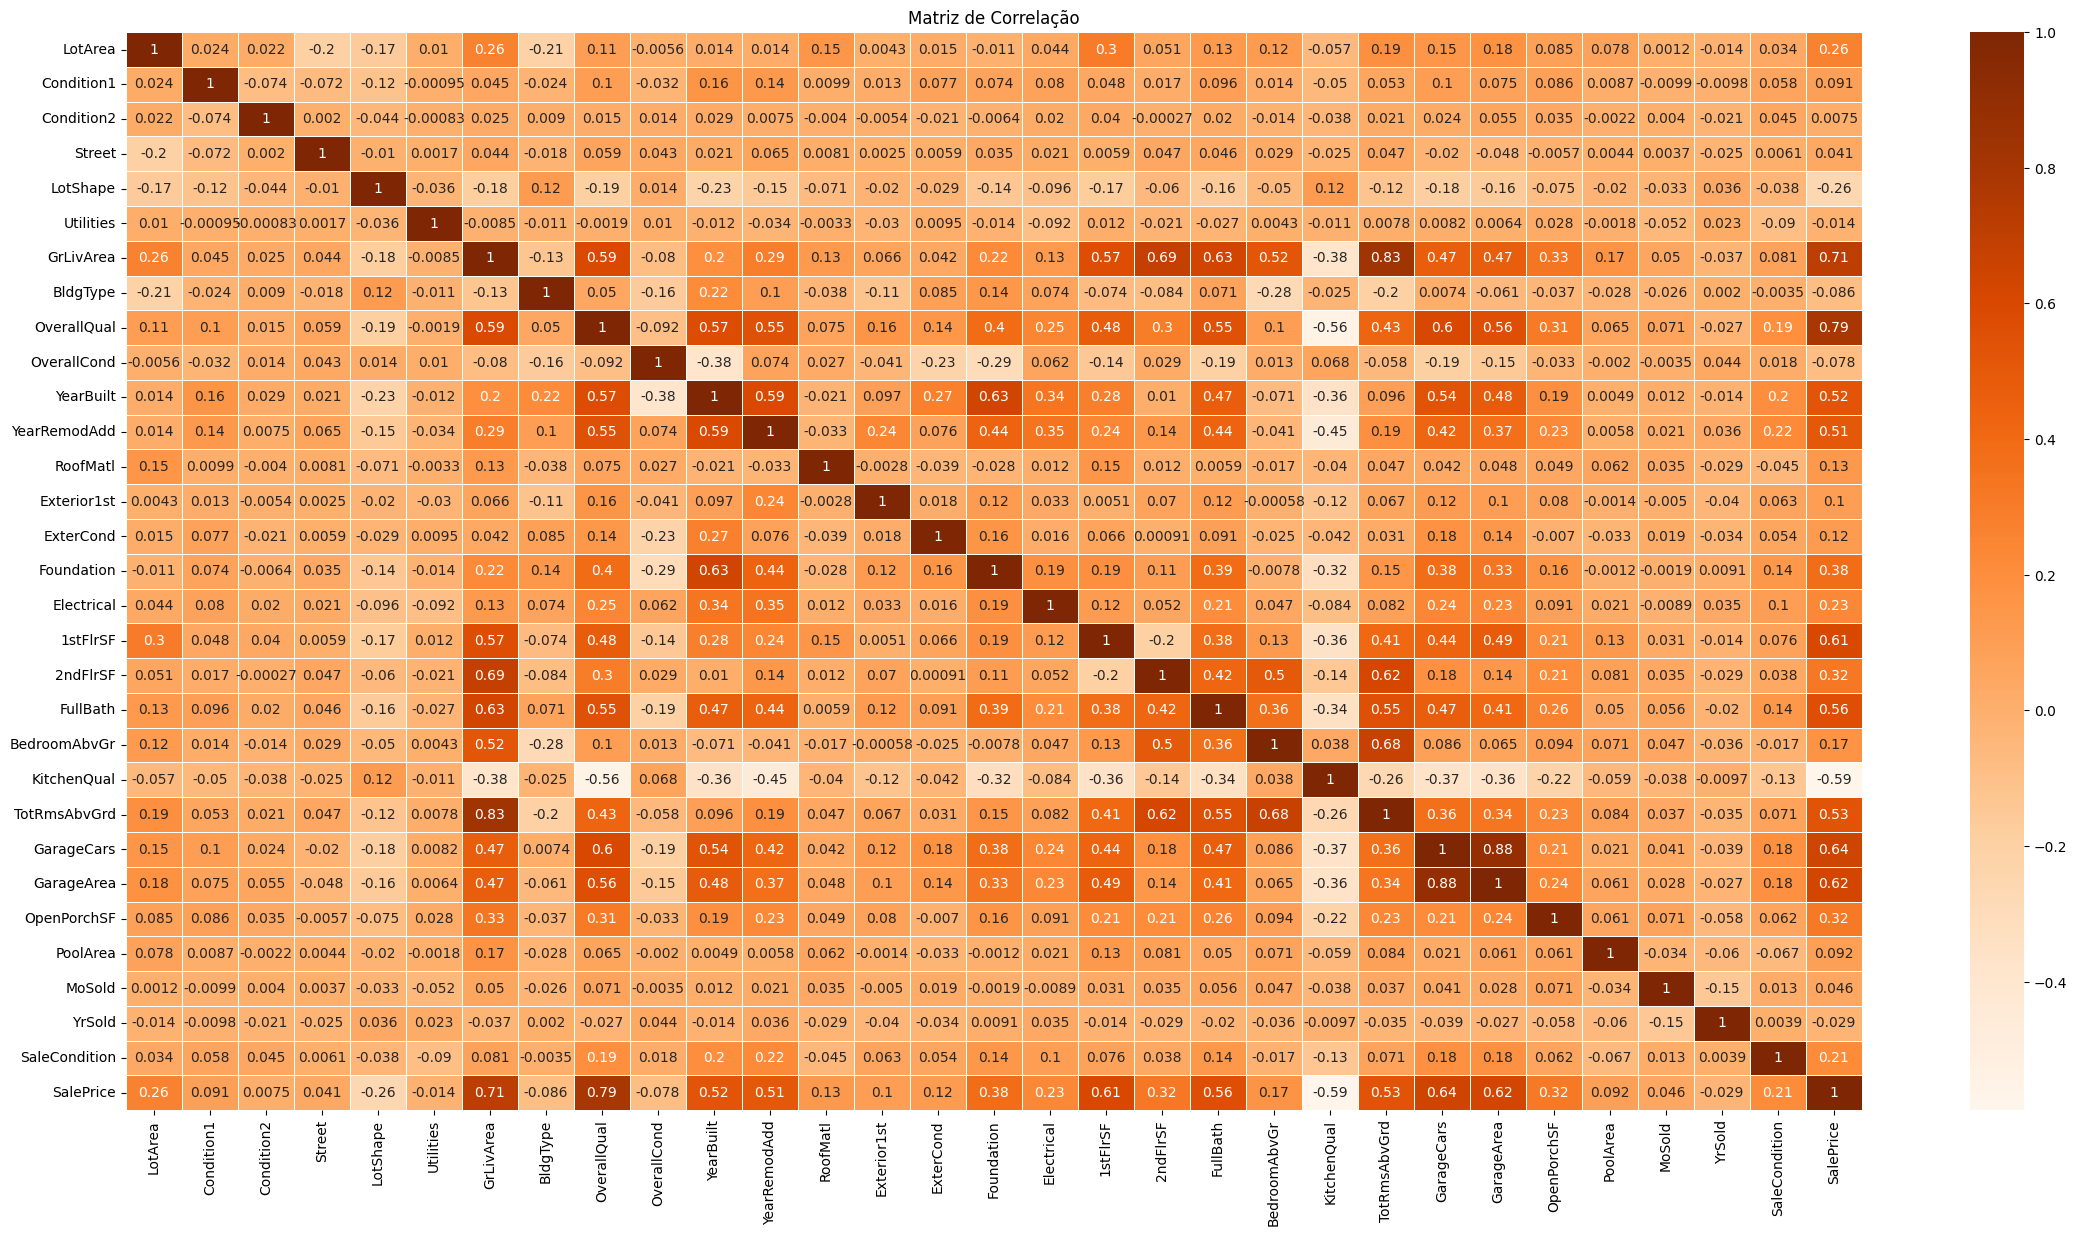

Variáveis fortemente correlacionadas com SalePrice:
Index(['GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF',
       'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')


In [5]:
# 3. Gerar a matriz de correlação de Pearson
correlation_matrix = df_corr.corr()

# 4. Plotando o heatmap para visualizar as correlações
plt.figure(figsize = (28,14)) 
sb.heatmap(correlation_matrix, annot=True, cmap='Oranges', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

# 5. Selecionar as variáveis mais correlacionadas com SalePrice (digamos acima de 0.5)
high_corr_features = correlation_matrix.index[abs(correlation_matrix["SalePrice"]) > 0.5]
print("Variáveis fortemente correlacionadas com SalePrice:")
print(high_corr_features)

In [6]:
lista_campos_forte_correlacao = [
    'OverallQual', # Qualidade geral do material e do acabamento
    'YearBuilt', # Data Original de construção
    'YearRemodAdd', # Data da reforma (igual à data de construção, se não houver reformas)
    '1stFlrSF', # Primeiro andar pés quadrados - converter para metros²
    'GrLivArea', # Área de estar acima do nível do solo (pés quadrados)
    'FullBath', # Banheiros completos
    'KitchenQual', # Qualidade da cozinha
    'TotRmsAbvGrd', # Total de cômodos acima do nível do solo (não inclui banheiros)
    'GarageCars', # Tamanho da garagem em capacidade de carros
    'GarageArea', # Tamanho da garagem em pés quadrados - converter para metros²
    'SalePrice', # Preço de Venda
]

# Padronizando variavel categorica, para transformar em numérica
# Decidi fazer a conversão manual, para replicar na aplicação Web e garantir a transformação correta

columns_categoricas =['KitchenQual']

dicionario_KitchenQual = {
       'Ex':0,
       'Fa':1,
       'Gd':2,
       'TA':3
       }

df['KitchenQual'] = df['KitchenQual'].map(dicionario_KitchenQual)

In [7]:
# Filtrando o dataset com as variáveis selecionadas
df_high_corr = df[lista_campos_forte_correlacao]

# 6. Dividir os dados em conjunto de treino e teste
X = df_high_corr.drop("SalePrice", axis=1)  # Features
y = df_high_corr["SalePrice"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
# Aplicando Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr_params = {'n_estimators': [300], 'learning_rate': [0.02], 'max_depth': [4]}
gbr_cv = GridSearchCV(gbr, gbr_params, scoring='neg_mean_squared_error', cv=5)
gbr_cv.fit(X_train, y_train)

# Prevendo valores
gbr_pred = gbr_cv.predict(X_test)

# Avaliação do modelo Gradient Boosting
print(f"Melhores parâmetros (GBR): {gbr_cv.best_params_}")
print(f"R² (GBR): {r2_score(y_test, gbr_pred)}")
print(f"MAE (GBR): {mean_absolute_error(y_test, gbr_pred)}")
print(f"RMSE (GBR): {np.sqrt(mean_squared_error(y_test, gbr_pred))}")

# Salvando modelo usando a biblioteca pickle
with open('./app_hackathon/modelo_regressao_linear_hackathon.pkl', 'wb') as f:
    pickle.dump(gbr_cv.best_estimator_, f)


Melhores parâmetros (GBR): {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 300}
R² (GBR): 0.8905152334785387
MAE (GBR): 18679.433652314165
RMSE (GBR): 27640.458863436146


### Testando o Modelo

In [9]:
lista_campos_teste = lista_campos_forte_correlacao[:len(lista_campos_forte_correlacao)-1]#.remove('SalePrice')

df_teste = pd.read_csv('./dados/train.csv')
df_teste = df_teste[lista_campos_forte_correlacao].head(1)



In [10]:
df_teste

,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,7,2003,2003,856,1710,2,Gd,8,2,548,208500


In [11]:
df_teste['KitchenQual'] = df_teste['KitchenQual'].map(dicionario_KitchenQual)
df_teste = df_teste.drop(columns='SalePrice')

In [12]:
import pickle
with open('./app_hackathon/modelo_regressao_linear_hackathon.pkl', 'rb') as f:
    model_p = pickle.load(f)
    print("modelo_pickle: ", model_p)

modelo_pickle:  GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=300)


In [13]:
# Fazer a previsão com o modelo treinado
sale_price_prediction = model_p.predict(df_teste)

print(f"Predição de SalePrice: {sale_price_prediction[0]}")

Predição de SalePrice: 198728.96605670193
